In [ ]:
#I will probably have to combine:
    #an ARIMA timeseries model
    #a linear regression model which takes into account time of day, weekend, eve of weekend, temperature and rain

In [17]:
#regression model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
bicing_for_model = pd.read_csv("data/bicing_final.csv")

In [3]:
dummy_columns = ['is_weekend_or_bank_holiday', 'is_eve_of_weekend_or_bank_holiday', 'time_of_day']

In [4]:
bicing_for_model_dummies = pd.get_dummies(bicing_for_model, columns=dummy_columns, drop_first=False, dtype=int)

In [5]:
bicing_for_model_dummies.sample(1)

Unnamed: 0  bikesInUsage  electricalBikesInUsage  \
8955        8955           381                       4   

      mechanicalBikesInUsage             dateTime  temperature  precipitation  \
8955                     377  2018-10-25 11:31:29    21.539999            0.0   

      is_weekend_or_bank_holiday_False  is_weekend_or_bank_holiday_True  \
8955                                 1                                0   

      is_eve_of_weekend_or_bank_holiday_False  \
8955                                        1   

      is_eve_of_weekend_or_bank_holiday_True  time_of_day_Afternoon  \
8955                                       0                      0   

      time_of_day_Evening  time_of_day_Morning  time_of_day_Night  
8955                    0                    1                  0

In [6]:
corr_bicing = bicing_for_model_dummies[["bikesInUsage", "temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]].corr()

In [7]:
corr_bicing

bikesInUsage  temperature  \
bikesInUsage                                1.000000     0.256415   
temperature                                 0.256415     1.000000   
precipitation                              -0.110473     0.039677   
is_weekend_or_bank_holiday_True            -0.259573    -0.038123   
is_eve_of_weekend_or_bank_holiday_True     -0.085190    -0.035909   
time_of_day_Morning                        -0.003293     0.001498   
time_of_day_Afternoon                       0.311094     0.296614   
time_of_day_Evening                         0.251980    -0.097233   
time_of_day_Night                          -0.561824    -0.202059   

                                        precipitation  \
bikesInUsage                                -0.110473   
temperature                                  0.039677   
precipitation                                1.000000   
is_weekend_or_bank_holiday_True              0.009417   
is_eve_of_weekend_or_bank_holiday_True       0.054220   
time_of_day_Morning                         -0.005240   
time_of_day_Afternoon                        0.005699   
time_of_day_Evening                         -0.029832   
time_of_day_Night                            0.029414   

                                        is_weekend_or_bank_holiday_True  \
bikesInUsage                                                  -0.259573   
temperature                                                   -0.038123   
precipitation                                                  0.009417   
is_weekend_or_bank_holiday_True                                1.000000   
is_eve_of_weekend_or_bank_holiday_True                         0.183119   
time_of_day_Morning                                           -0.000351   
time_of_day_Afternoon                                         -0.002992   
time_of_day_Evening                                            0.000669   
time_of_day_Night                                              0.002687   

                                        is_eve_of_weekend_or_bank_holiday_True  \
bikesInUsage                                                         -0.085190   
temperature                                                          -0.035909   
precipitation                                                         0.054220   
is_weekend_or_bank_holiday_True                                       0.183119   
is_eve_of_weekend_or_bank_holiday_True                                1.000000   
time_of_day_Morning                                                   0.002113   
time_of_day_Afternoon                                                -0.003011   
time_of_day_Evening                                                  -0.003501   
time_of_day_Night                                                     0.004416   

                                        time_of_day_Morning  \
bikesInUsage                                      -0.003293   
temperature                                        0.001498   
precipitation                                     -0.005240   
is_weekend_or_bank_holiday_True                   -0.000351   
is_eve_of_weekend_or_bank_holiday_True             0.002113   
time_of_day_Morning                                1.000000   
time_of_day_Afternoon                             -0.334771   
time_of_day_Evening                               -0.333368   
time_of_day_Night                                 -0.331725   

                                        time_of_day_Afternoon  \
bikesInUsage                                         0.311094   
temperature                                          0.296614   
precipitation                                        0.005699   
is_weekend_or_bank_holiday_True                     -0.002992   
is_eve_of_weekend_or_bank_holiday_True              -0.003011   
time_of_day_Morning                                 -0.334771   
time_of_day_Afternoon                                1.000000   
time_of_day_Evening                                 -0.

In [8]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")

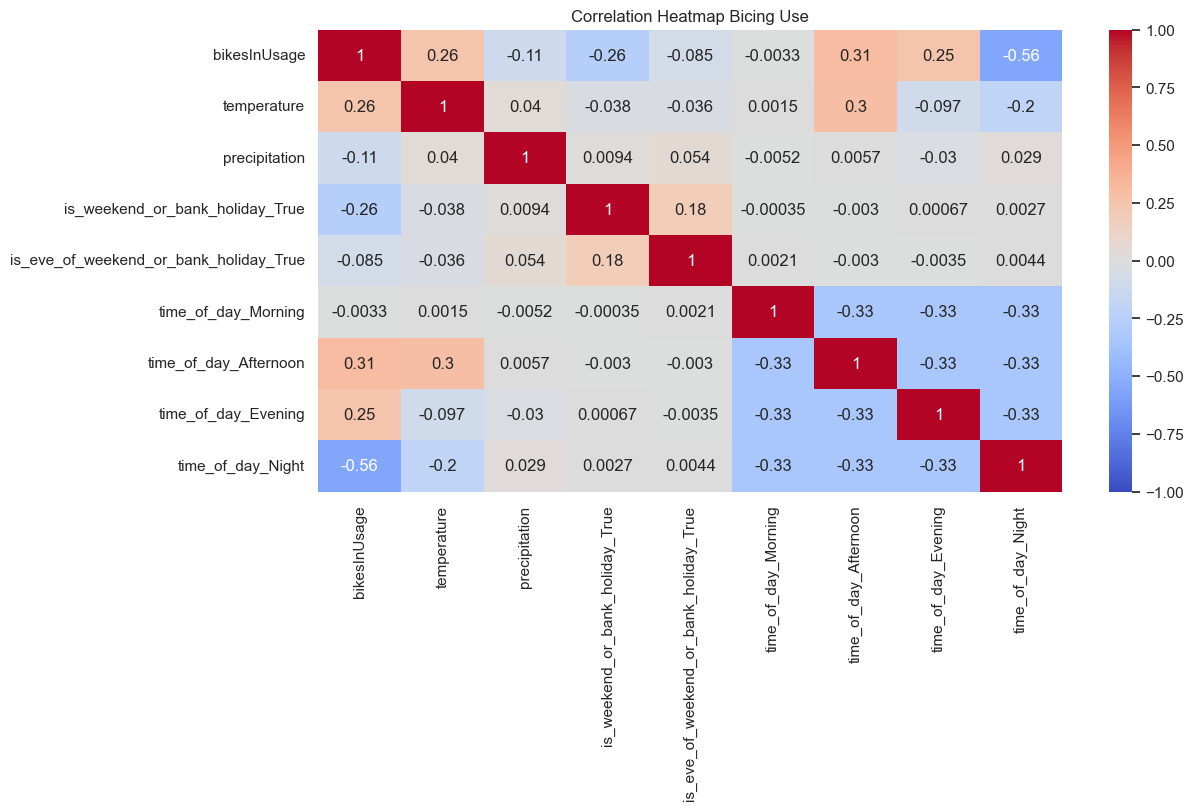

In [9]:
sns.heatmap(corr_bicing, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Bicing Use')
plt.show()

In [10]:
bicing_for_model_dummies.isna().sum()

Unnamed: 0                                  0
bikesInUsage                                0
electricalBikesInUsage                      0
mechanicalBikesInUsage                      0
dateTime                                    0
temperature                                12
precipitation                              12
is_weekend_or_bank_holiday_False            0
is_weekend_or_bank_holiday_True             0
is_eve_of_weekend_or_bank_holiday_False     0
is_eve_of_weekend_or_bank_holiday_True      0
time_of_day_Afternoon                       0
time_of_day_Evening                         0
time_of_day_Morning                         0
time_of_day_Night                           0
dtype: int64

In [11]:
bicing_for_model_dummies.isna().sum()

Unnamed: 0                                  0
bikesInUsage                                0
electricalBikesInUsage                      0
mechanicalBikesInUsage                      0
dateTime                                    0
temperature                                12
precipitation                              12
is_weekend_or_bank_holiday_False            0
is_weekend_or_bank_holiday_True             0
is_eve_of_weekend_or_bank_holiday_False     0
is_eve_of_weekend_or_bank_holiday_True      0
time_of_day_Afternoon                       0
time_of_day_Evening                         0
time_of_day_Morning                         0
time_of_day_Night                           0
dtype: int64

In [12]:
bicing_for_model_dummies = bicing_for_model_dummies.dropna()

In [13]:
X = bicing_for_model_dummies[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]]
y = bicing_for_model_dummies.bikesInUsage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
bicing_linreg = LinReg()

In [15]:
bicing_linreg.fit(X_train, y_train)

LinearRegression()

In [16]:
#evaluating on training data

In [17]:
y_pred = bicing_linreg.predict(X_test)
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: 0.4502451066646532


In [18]:
np.sqrt(mean_squared_error(y_pred, y_test))

177.0658372894752

In [19]:
#haha

In [20]:
#trying to play around a bit with the variables but pretty sure linear regression is dead

In [21]:
#removing colinear variables

In [22]:
X = bicing_for_model_dummies[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Night"]]
y = bicing_for_model_dummies.bikesInUsage

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [24]:
bicing_linreg_2 = LinReg()

In [25]:
bicing_linreg_2.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = bicing_linreg_2.predict(X_test)
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: 0.3941015130249719


In [27]:
np.sqrt(mean_squared_error(y_pred, y_test))

177.06444859734657

In [28]:
#reducing test sample size = better, removing colinear variables = worse
#keep playing around
#removing 2 variables with least correlation (time of day morning + is eve of weekend or bank holiday)

In [29]:
X = bicing_for_model_dummies[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]]
y = bicing_for_model_dummies.bikesInUsage

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [31]:
bicing_linreg_3 = LinReg()

In [32]:
bicing_linreg_3.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = bicing_linreg_3.predict(X_test)
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: 0.4460257822295045


In [34]:
np.sqrt(mean_squared_error(y_pred, y_test))

179.87142248735228

In [35]:
#This is the best one so far, worth taking into account as I try diff models

In [36]:
X = bicing_for_model_dummies[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]]
y = bicing_for_model_dummies.bikesInUsage

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [38]:
bicing_RFR = RFR()

In [39]:
bicing_RFR.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
y_pred = bicing_RFR.predict(X_train)
print(f"r2: {metrics.r2_score(y_train, y_pred)}")

r2: 0.875284335377817


In [41]:
np.sqrt(mean_squared_error(y_pred, y_train))

83.05162213667101

In [42]:
y_pred = bicing_RFR.predict(X_test)
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: 0.8609665007851961


In [43]:
np.sqrt(mean_squared_error(y_pred, y_test))

87.96850057263312

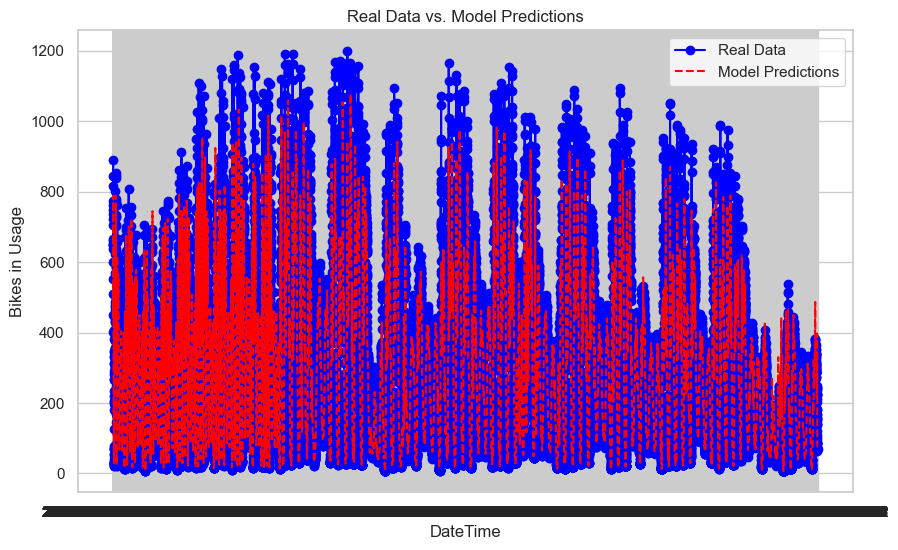

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(bicing_for_model_dummies['dateTime'], bicing_for_model_dummies['bikesInUsage'], label='Real Data', marker='o', linestyle='-', color='blue')
plt.plot(bicing_for_model_dummies['dateTime'], bicing_RFR.predict(X), label='Model Predictions', linestyle='--', color='red')

plt.xlabel('DateTime')
plt.ylabel('Bikes in Usage')
plt.title('Real Data vs. Model Predictions')
plt.legend()
plt.show()

In [103]:
#RFR best one yet!! - all variables again, split at 0.1

In [152]:
X = bicing_for_model_dummies[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Night"]]
y = bicing_for_model_dummies.bikesInUsage

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [154]:
bicing_GBR = GBR()

In [155]:
bicing_GBR.fit(X_train, y_train)

GradientBoostingRegressor()

In [156]:
y_pred = bicing_GBR.predict(X_test)
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: 0.5503690246862631


In [157]:
np.sqrt(mean_squared_error(y_pred, y_test))

159.85912578564356

In [ ]:
#Boo GBR

In [158]:
#Now going to try ARIMA, maybe ARIMAX, and Prophet, and maybe LSTM

CHATGPT: 

ARIMA with Exogenous Variables (ARIMAX):
Combines ARIMA with additional exogenous (external) variables.
Allows you to include your categorical features.

Prophet with Regressors:
Prophet can be extended to include additional regressors.
Enables incorporating external features into the time series model.

LSTM with Additional Features:
You can concatenate additional features with the LSTM input.
Allows the model to learn from both time series and external features.


In [168]:
#ARIMA

In [313]:
#Update Monday - to use AR it has to have regualar intervals in the datetime index

In [183]:
bicing_for_timeseries_model = bicing_for_model_dummies.set_index('dateTime')

In [184]:
bicing_for_timeseries_model = bicing_for_timeseries_model.drop('Unnamed: 0', axis = 1)

In [ ]:
#Checking autocorrelation and stationarity

In [188]:
def plotting_acf (df):
    plot_acf(bicing_for_timeseries_model.bikesInUsage);
    plt.title("Autocorrelation of Bikes in Usage: value of correlation across different # of lags", size=20)
    plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


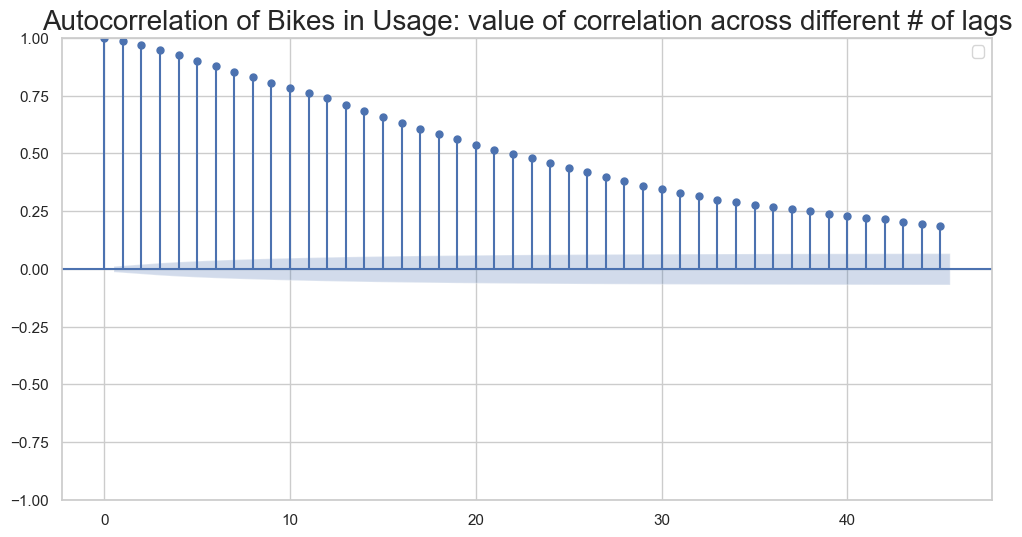

In [189]:
plotting_acf (bicing_for_timeseries_model)

In [190]:
#Gradual decrease in the ACF

In [192]:
def plotting_partial (df):
    plot_pacf(bicing_for_timeseries_model.bikesInUsage)
    plt.title("Partial autocorrelation of Bikes in Usage: value of correlation across different # of lags", size=20);

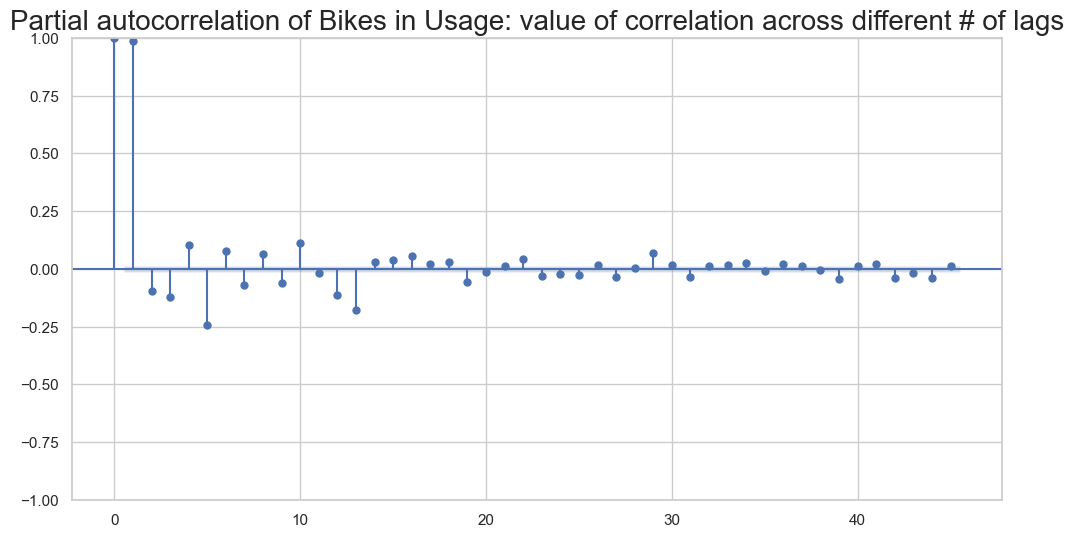

In [193]:
plotting_partial (bicing_for_timeseries_model)

In [195]:
#Sharp drop in the PACF; model to use is AR (p)

In [ ]:
#Now going to check for stationarity

In [198]:
res = adfuller(bicing_for_timeseries_model["bikesInUsage"])
res

(-16.48152237702041,
 2.2348729982019534e-29,
 49,
 25906,
 {'1%': -3.4306024491653035,
  '5%': -2.8616515750597045,
  '10%': -2.5668293881120388},
 260260.54483788027)

In [199]:
p_value = res[1]

In [202]:
def dickey_rejects (bicing_for_timeseries_model, alpha = 0.05):
    
    p_value = adfuller(bicing_for_timeseries_model)[0]
    
    h0 = "The series is NOT stationary"
    h1 = "The series IS stationary"
    
    if p_value < alpha:
        return f"We reject H0 and accept H1: {h1}"
    
    elif p_value > alpha:
        return f"We don't have enough info to reject H0, so we keep H0: {h0}"

In [203]:
dickey_rejects(bicing_for_timeseries_model["bikesInUsage"])

'We reject H0 and accept H1: The series IS stationary'

In [204]:
#Amazing. 
#So we use AR and it is stationary

In [207]:
from statsmodels.tsa.api import acf, pacf
from statsmodels.tsa.stattools import arma_order_select_ic

# Determine lag order using AIC
order_aic = arma_order_select_ic(bicing_for_timeseries_model['bikesInUsage'], ic='aic', trend='c')
print(f'Best lag order based on AIC: {order_aic["aic_min_order"]}')

/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Best lag order based on AIC: (2, 2)


In [208]:
#aligns with the sharp drop in the PACF

In [210]:
#Now to make the AR model

In [311]:
y_train = bicing_for_timeseries_model["bikesInUsage"][:-3000]
y_test = bicing_for_timeseries_model["bikesInUsage"][-3001:]

In [307]:
bicing_AR = AutoReg(y_train, lags=2)
bicing_AR = bicing_AR.fit()

/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [308]:
y_pred = bicing_AR.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [309]:
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: -0.8302715851909335


In [310]:
np.sqrt(mean_squared_error(y_pred, y_test))

189.81721738505547

In [298]:
#suspiciously high, not sure what's going on here
#correction - piece of crap lol
#it was high because i was training the model on the entire data set

In [ ]:
#let's try ARMAX

In [299]:
exog_data_train = bicing_for_timeseries_model[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]][:-3000]
exog_data_test = bicing_for_timeseries_model[["temperature", "precipitation", "is_weekend_or_bank_holiday_True", "is_eve_of_weekend_or_bank_holiday_True", "time_of_day_Morning", "time_of_day_Afternoon", "time_of_day_Evening", "time_of_day_Night"]][-3001:]

# Assuming 'bikesInUsage' is your target variable
y_train = bicing_for_timeseries_model["bikesInUsage"][:-3000]
y_test = bicing_for_timeseries_model["bikesInUsage"][-3001:]

# Fit ARMAX model
order = (2, 0, 0)  # Adjust order based on your analysis
model = ARIMA(y_train, order=order, exog=exog_data_train)
bicing_ARMAX = model.fit()

# Make predictions on the test set
y_pred = bicing_ARMAX.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=exog_data_test)

/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edwardrodger/miniconda3/envs/final_project/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been pr

In [300]:
print(f"r2: {metrics.r2_score(y_test, y_pred)}")

r2: -3.795141827985728


In [301]:
np.sqrt(mean_squared_error(y_pred, y_test))

307.2405701804126

In [312]:
#load of shit